# IMPORTING THE LIBRARIES

In [82]:
import os
import pandas as pd
import pickle
import numpy as np
import seaborn as sns
import tensorflow as tf
from sklearn.datasets import load_files
import keras.utils
import matplotlib.pyplot as plt
from keras.layers import Conv2D, MaxPooling2D, GlobalAveragePooling2D
from keras.layers import Dropout, Flatten, Dense
from keras.models import Sequential
from keras.callbacks import ModelCheckpoint
from keras.utils import to_categorical
from sklearn.metrics import confusion_matrix
from keras.preprocessing import image 
from tqdm import tqdm
import seaborn as sns
from sklearn.metrics import accuracy_score,precision_score,recall_score,f1_score

In [83]:
# Pretty display for notebooks
%matplotlib inline

In [84]:
!dir

 Volume in drive D is DATA
 Volume Serial Number is 84CA-9485

 Directory of d:\New folder\Distracted Driver Detection using DL\Distracted Driver Detection using DL\Training Notebooks

02-01-2024  01:54    <DIR>          .
02-01-2024  01:54    <DIR>          ..
02-01-2024  01:54    <DIR>          .ipynb_checkpoints
02-01-2024  01:54    <DIR>          csv_files
17-01-2024  21:27           313,025 Custom CNN Non Batch.ipynb
02-01-2024  02:52    <DIR>          model
02-01-2024  01:54    <DIR>          pickle_files
23-03-2023  23:59    <DIR>          pred_dir
               1 File(s)        313,025 bytes
               7 Dir(s)  562,731,450,368 bytes free


# Defining the train,test and model directories

We will create the directories for train,test and model training paths if not present

In [85]:
TEST_DIR = "D:/New folder/Distracted Driver Detection using DL/Distracted Driver Detection using DL/test2"
TRAIN_DIR = "D:/New folder/Distracted Driver Detection using DL/Distracted Driver Detection using DL/train1"
MODEL_PATH = "D:/New folder/Distracted Driver Detection using DL/Distracted Driver Detection using DL/Training Notebooks/model"
PICKLE_DIR = "D:/New folder/Distracted Driver Detection using DL/Distracted Driver Detection using DL/Training Notebooks/pickle_files"
CSV_DIR = "D:/New folder/Distracted Driver Detection using DL/Distracted Driver Detection using DL/Training Notebooks/csv_files"

In [86]:
if not os.path.exists(TEST_DIR):
    print("Testing data does not exists")
if not os.path.exists(TRAIN_DIR):
    print("Training data does not exists")
if not os.path.exists(MODEL_PATH):
    print("Model path does not exists")
    os.makedirs(MODEL_PATH)
    print("Model path created")
if not os.path.exists(PICKLE_DIR):
    os.makedirs(PICKLE_DIR)
if not os.path.exists(CSV_DIR):
    os.makedirs(CSV_DIR)

# Data Preparation

We will create a csv file having the location of the files present for training and test images and their associated class if present so that it is easily traceable.

In [87]:
def create_csv(DATA_DIR,filename):
    class_names = os.listdir(DATA_DIR)
    data = list()
    if(os.path.isdir(os.path.join(DATA_DIR,class_names[0]))):
        for class_name in class_names:
            file_names = os.listdir(os.path.join(DATA_DIR,class_name))
            for file in file_names:
                data.append({
                    "Filename":os.path.join(DATA_DIR,class_name,file),
                    "ClassName":class_name
                })
    else:
        class_name = "test"
        file_names = os.listdir(DATA_DIR)
        for file in file_names:
            data.append(({
                "FileName":os.path.join(DATA_DIR,file),
                "ClassName":class_name
            }))
    data = pd.DataFrame(data)
    data.to_csv(os.path.join(os.getcwd(),"csv_files",filename),index=False)

create_csv(TRAIN_DIR,"train.csv")
create_csv(TEST_DIR,"test.csv")
data_train = pd.read_csv(os.path.join(os.getcwd(),"csv_files","train.csv"))
data_test = pd.read_csv(os.path.join(os.getcwd(),"csv_files","test.csv"))


In [88]:
data_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3012 entries, 0 to 3011
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   Filename   3012 non-null   object
 1   ClassName  3012 non-null   object
dtypes: object(2)
memory usage: 47.2+ KB


In [89]:
data_train['ClassName'].value_counts()

ClassName
c2    312
c0    300
c1    300
c3    300
c4    300
c5    300
c6    300
c7    300
c8    300
c9    300
Name: count, dtype: int64

In [90]:
data_train.describe()

,Filename,ClassName
count,3012,3012
unique,3012,10
top,D:/New folder/Distracted Driver Detection usin...,c2
freq,1,312


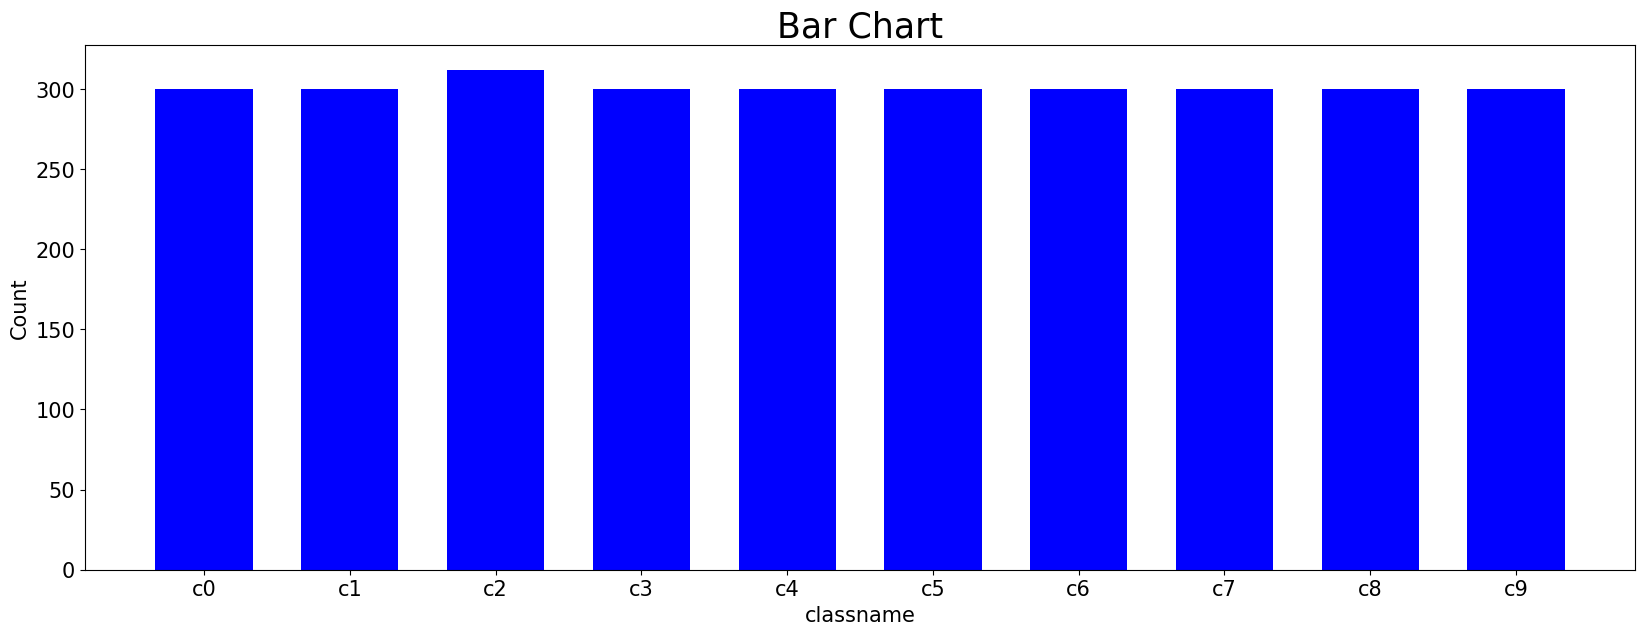

In [91]:


nf = data_train['ClassName'].value_counts(sort=False)
labels = data_train['ClassName'].value_counts(sort=False).index.tolist()
y = np.array(nf)
width = 1/1.5
N = len(y)
x = range(N)

fig = plt.figure(figsize=(20,15))
ay = fig.add_subplot(211)

plt.xticks(x, labels, size=15)
plt.yticks(size=15)

ay.bar(x, y, width, color="blue")

plt.title('Bar Chart',size=25)
plt.xlabel('classname',size=15)
plt.ylabel('Count',size=15)

plt.show()

In [92]:
data_test.head()

,Filename,ClassName
0,D:/New folder/Distracted Driver Detection usin...,c0
1,D:/New folder/Distracted Driver Detection usin...,c0
2,D:/New folder/Distracted Driver Detection usin...,c0
3,D:/New folder/Distracted Driver Detection usin...,c0
4,D:/New folder/Distracted Driver Detection usin...,c0


In [93]:
data_test.shape

(3013, 2)

## Observation:
1. There are total 22424 training samples
2. There are total 79726 training samples
3. The training dataset is equally balanced to a great extent and hence we need not do any downsampling of the data

## Converting into numerical values

In [94]:
labels_list = list(set(data_train['ClassName'].values.tolist()))
labels_id = {label_name:id for id,label_name in enumerate(labels_list)}
print(labels_id)
data_train['ClassName'].replace(labels_id,inplace=True)

{'c4': 0, 'c2': 1, 'c1': 2, 'c6': 3, 'c7': 4, 'c9': 5, 'c3': 6, 'c8': 7, 'c0': 8, 'c5': 9}


In [95]:
with open(os.path.join(os.getcwd(),"pickle_files","labels_list.pkl"),"wb") as handle:
    pickle.dump(labels_id,handle)

In [96]:
labels = to_categorical(data_train['ClassName'])
print(labels.shape)

(3012, 10)


## Splitting into Train and Test sets

In [97]:
from sklearn.model_selection import train_test_split

xtrain,xtest,ytrain,ytest = train_test_split(data_train.iloc[:,0],labels,test_size = 0.2,random_state=42)

### Converting into 64*64 images 
You can substitute 64,64 to 224,224 for better results only if ram is >32gb

In [98]:

def path_to_tensor(img_path):
    # loads RGB image as PIL.Image.Image type
    img = image.load_img(img_path, target_size=(128, 128))
    # convert PIL.Image.Image type to 3D tensor with shape (224, 224, 3)
    x = image.img_to_array(img)
    # convert 3D tensor to 4D tensor with shape (1, 224, 224, 3) and return 4D tensor
    return np.expand_dims(x, axis=0)

def paths_to_tensor(img_paths):
    list_of_tensors = [path_to_tensor(img_path) for img_path in tqdm(img_paths)]
    return np.vstack(list_of_tensors)

In [99]:
import keras.utils as image
from PIL import ImageFile                            
ImageFile.LOAD_TRUNCATED_IMAGES = True                 

# pre-process the data for Keras
train_tensors = paths_to_tensor(xtrain).astype('float32')/255 - 0.5


100%|██████████| 2409/2409 [00:26<00:00, 92.34it/s] 


In [100]:
valid_tensors = paths_to_tensor(xtest).astype('float32')/255 - 0.5


100%|██████████| 603/603 [00:05<00:00, 100.53it/s]


In [101]:
##takes too much ram 
## run this if your ram is greater than 16gb 
# test_tensors = paths_to_tensor(data_test.iloc[:,0]).astype('float32')/255 - 0.5 

# Defining the Model

w

In [102]:
model = Sequential()

model.add(Conv2D(filters=64, kernel_size=2, padding='same', activation='relu', input_shape=(128,128,3), kernel_initializer='glorot_normal'))
model.add(MaxPooling2D(pool_size=2))
model.add(Conv2D(filters=128, kernel_size=2, padding='same', activation='relu', kernel_initializer='glorot_normal'))
model.add(MaxPooling2D(pool_size=2))
model.add(Conv2D(filters=256, kernel_size=2, padding='same', activation='relu', kernel_initializer='glorot_normal'))
model.add(MaxPooling2D(pool_size=2))
model.add(Conv2D(filters=512, kernel_size=2, padding='same', activation='relu', kernel_initializer='glorot_normal'))
model.add(MaxPooling2D(pool_size=2))
model.add(Dropout(0.5))
model.add(Flatten())
model.add(Dense(500, activation='relu', kernel_initializer='glorot_normal'))
model.add(Dropout(0.5))
model.add(Dense(10, activation='softmax', kernel_initializer='glorot_normal'))


model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_12 (Conv2D)          (None, 128, 128, 64)      832       
                                                                 
 max_pooling2d_12 (MaxPooli  (None, 64, 64, 64)        0         
 ng2D)                                                           
                                                                 
 conv2d_13 (Conv2D)          (None, 64, 64, 128)       32896     
                                                                 
 max_pooling2d_13 (MaxPooli  (None, 32, 32, 128)       0         
 ng2D)                                                           
                                                                 
 conv2d_14 (Conv2D)          (None, 32, 32, 256)       131328    
                                                                 
 max_pooling2d_14 (MaxPooli  (None, 16, 16, 256)      

In [113]:
#tf.keras.utils.plot_model(model,to_file=os.path.join(MODEL_PATH,"model_distracted_driver.png"),show_shapes=True,show_layer_names=True)

In [110]:
model.compile(optimizer='rmsprop', loss='categorical_crossentropy', metrics=['accuracy'])

In [111]:
filepath = os.path.join(MODEL_PATH,"distracted-{epoch:02d}-{val_accuracy:.2f}.hdf5")
checkpoint = ModelCheckpoint(filepath, monitor='val_accuracy', verbose=1, save_best_only=True, mode='max',period=1)
callbacks_list = [checkpoint]

In [112]:
model_history = model.fit(train_tensors,ytrain,validation_data = (valid_tensors, ytest),epochs=25, batch_size=40, shuffle=True,callbacks=callbacks_list)

Epoch 1/25
61/61 [==============================] - ETA: 0s - loss: 2.2567 - accuracy: 0.1582
Epoch 1: val_accuracy improved from -inf to 0.31841, saving model to D:/New folder/Distracted Driver Detection using DL/Distracted Driver Detection using DL/Training Notebooks/model\distracted-01-0.32.hdf5


c:\Users\gjosh\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\engine\training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


61/61 [==============================] - 80s 1s/step - loss: 2.2567 - accuracy: 0.1582 - val_loss: 1.8198 - val_accuracy: 0.3184
Epoch 2/25
61/61 [==============================] - ETA: 0s - loss: 1.5392 - accuracy: 0.4711
Epoch 2: val_accuracy improved from 0.31841 to 0.47927, saving model to D:/New folder/Distracted Driver Detection using DL/Distracted Driver Detection using DL/Training Notebooks/model\distracted-02-0.48.hdf5
61/61 [==============================] - 58s 950ms/step - loss: 1.5392 - accuracy: 0.4711 - val_loss: 1.5103 - val_accuracy: 0.4793
Epoch 3/25
61/61 [==============================] - ETA: 0s - loss: 1.1042 - accuracy: 0.6276
Epoch 3: val_accuracy improved from 0.47927 to 0.70978, saving model to D:/New folder/Distracted Driver Detection using DL/Distracted Driver Detection using DL/Training Notebooks/model\distracted-03-0.71.hdf5
61/61 [==============================] - 57s 933ms/step - loss: 1.1042 - accuracy: 0.6276 - val_loss: 0.8215 - val_accuracy: 0.7098
E

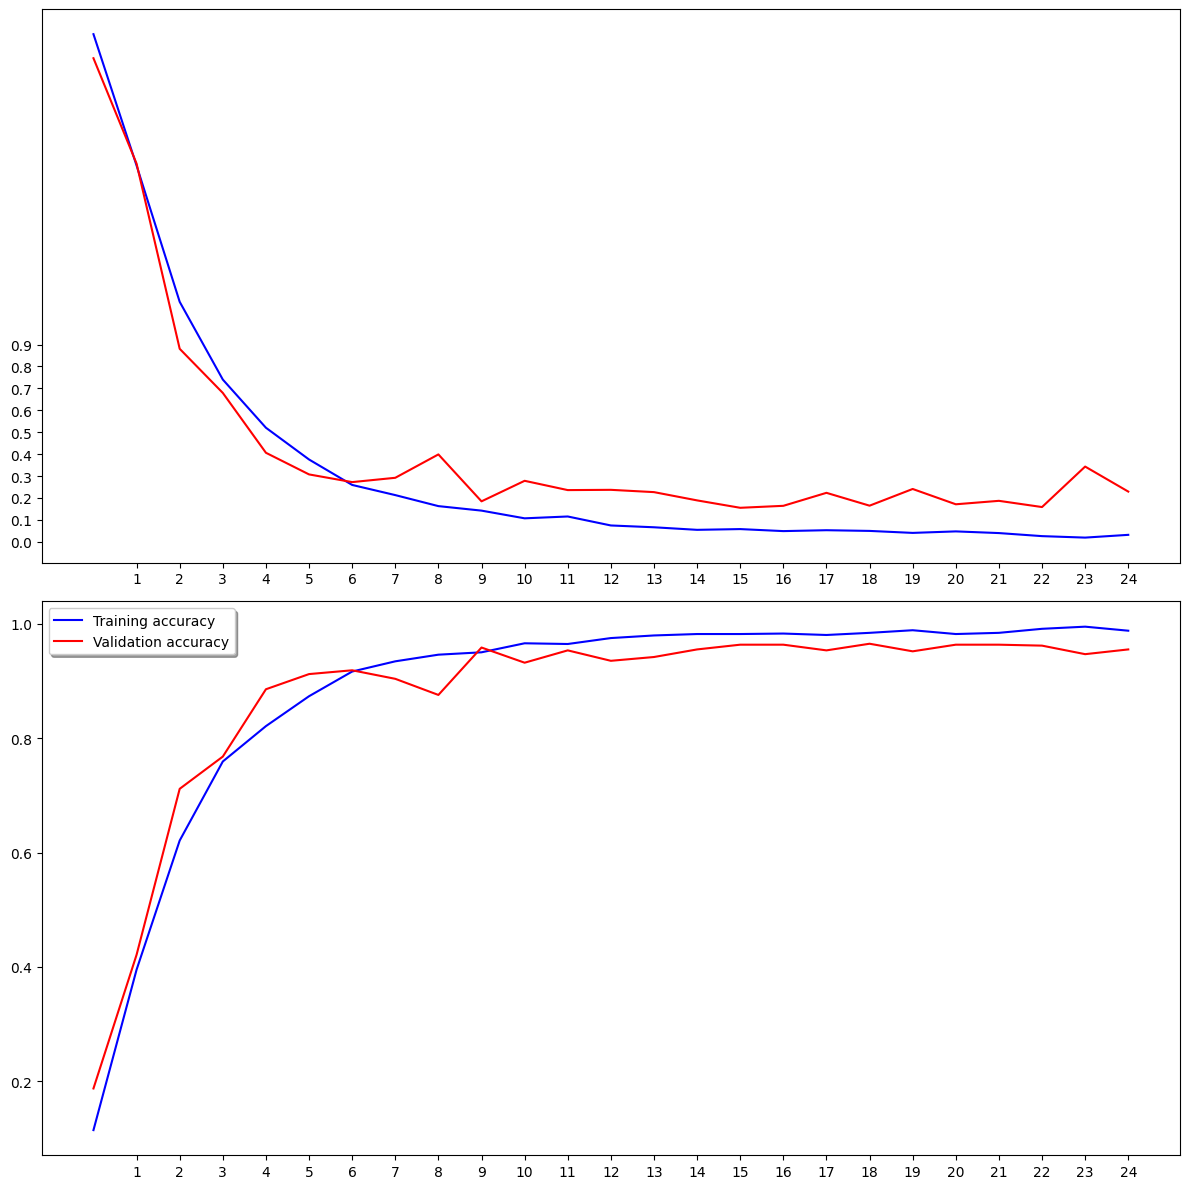

In [ ]:
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 12))
ax1.plot(model_history.history['loss'], color='b', label="Training loss")
ax1.plot(model_history.history['val_loss'], color='r', label="validation loss")
ax1.set_xticks(np.arange(1, 25, 1))
ax1.set_yticks(np.arange(0, 1, 0.1))

ax2.plot(model_history.history['accuracy'], color='b', label="Training accuracy")
ax2.plot(model_history.history['val_accuracy'], color='r',label="Validation accuracy")
ax2.set_xticks(np.arange(1, 25, 1))

legend = plt.legend(loc='best', shadow=True)
plt.tight_layout()
plt.show()

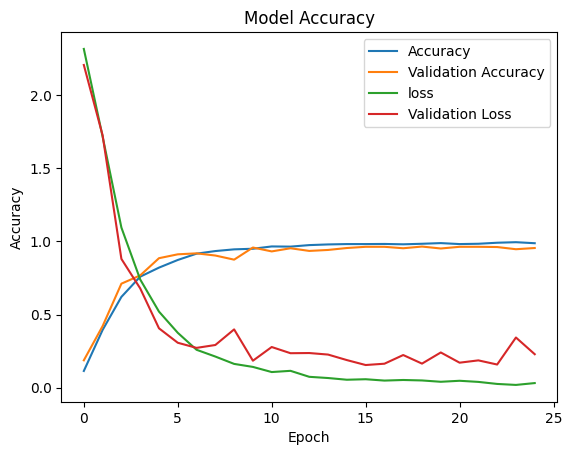

In [ ]:
import matplotlib.pyplot as plt
plt.plot(model_history.history["accuracy"])
plt.plot(model_history.history['val_accuracy'])
plt.plot(model_history.history['loss'])
plt.plot(model_history.history['val_loss'])
plt.title("Model Accuracy")
plt.ylabel("Accuracy")
plt.xlabel("Epoch")
plt.legend(["Accuracy","Validation Accuracy","loss","Validation Loss"])
plt.show()

# Model Analysis

Finding the Confusion matrix,Precision,Recall and F1 score to analyse the model thus created 

In [ ]:

def print_confusion_matrix(confusion_matrix, class_names, figsize = (10,7), fontsize=14):
    df_cm = pd.DataFrame(
        confusion_matrix, index=class_names, columns=class_names, 
    )
    fig = plt.figure(figsize=figsize)
    try:
        heatmap = sns.heatmap(df_cm, annot=True, fmt="d")
    except ValueError:
        raise ValueError("Confusion matrix values must be integers.")
    heatmap.yaxis.set_ticklabels(heatmap.yaxis.get_ticklabels(), rotation=0, ha='right', fontsize=fontsize)
    heatmap.xaxis.set_ticklabels(heatmap.xaxis.get_ticklabels(), rotation=45, ha='right', fontsize=fontsize)
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    fig.savefig(os.path.join(MODEL_PATH,"confusion_matrix.png"))
    return fig


In [ ]:
def print_heatmap(n_labels, n_predictions, class_names):
    labels = n_labels #sess.run(tf.argmax(n_labels, 1))
    predictions = n_predictions #sess.run(tf.argmax(n_predictions, 1))

#     confusion_matrix = sess.run(tf.contrib.metrics.confusion_matrix(labels, predictions))
    matrix = confusion_matrix(labels.argmax(axis=1),predictions.argmax(axis=1))
    row_sum = np.sum(matrix, axis = 1)
    w, h = matrix.shape

    c_m = np.zeros((w, h))

    for i in range(h):
        c_m[i] = matrix[i] * 100 / row_sum[i]

    c = c_m.astype(dtype = np.uint8)

    
    heatmap = print_confusion_matrix(c, class_names, figsize=(18,10), fontsize=20)


In [ ]:
class_names = list()
for name,idx in labels_id.items():
    class_names.append(name)
# print(class_names)
ypred = model.predict(valid_tensors)

19/19 [==============================] - 5s 235ms/step


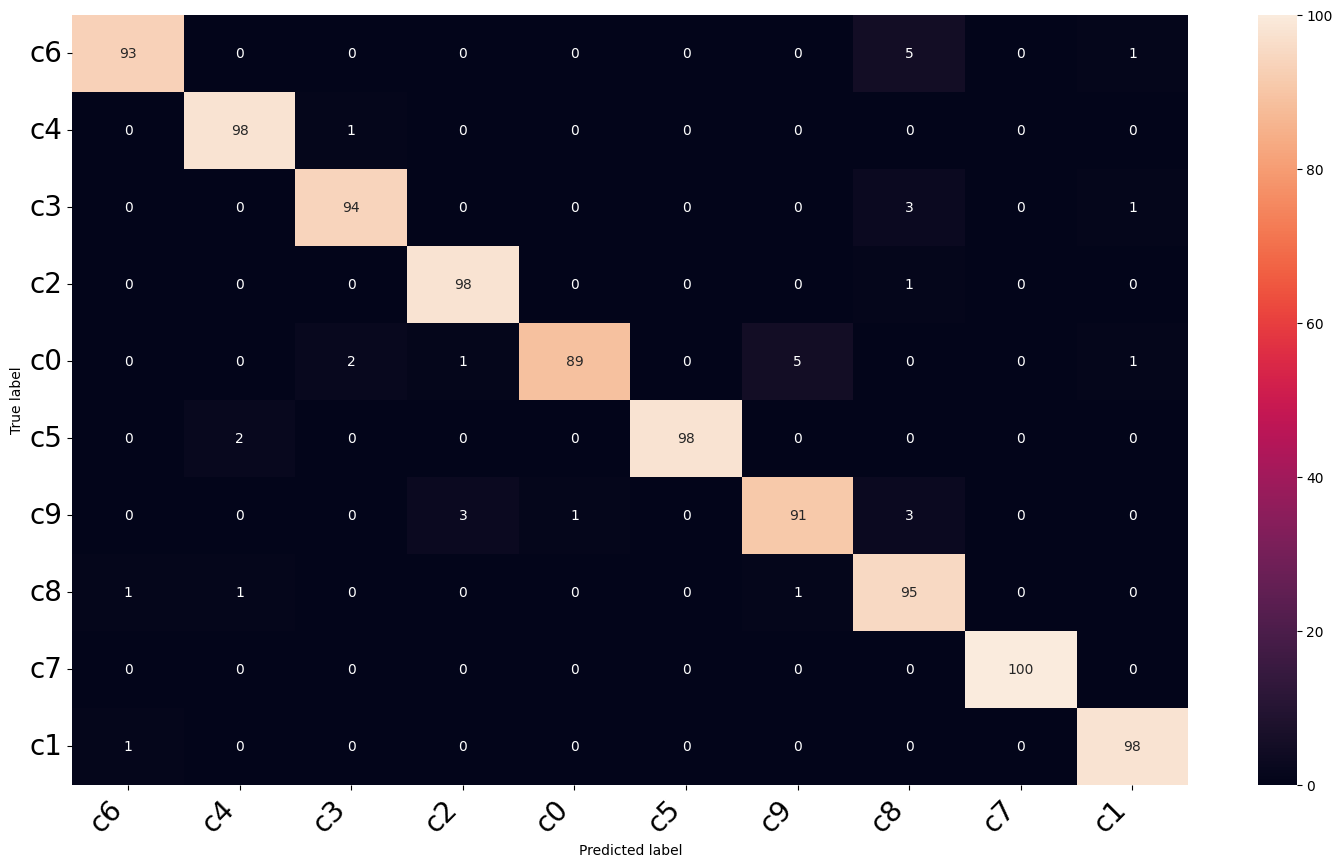

In [ ]:
print_heatmap(ytest,ypred,class_names)

## Precision Recall F1 Score

In [ ]:
ypred_class = np.argmax(ypred,axis=1)
# print(ypred_class[:10])
ytest = np.argmax(ytest,axis=1)

In [ ]:
accuracy = accuracy_score(ytest,ypred_class)
print('Accuracy: %f' % accuracy)
# precision tp / (tp + fp)
precision = precision_score(ytest, ypred_class,average='weighted')
print('Precision: %f' % precision)
# recall: tp / (tp + fn)
recall = recall_score(ytest,ypred_class,average='weighted')
print('Recall: %f' % recall)
# f1: 2 tp / (2 tp + fp + fn)
f1 = f1_score(ytest,ypred_class,average='weighted')
print('F1 score: %f' % f1)

Accuracy: 0.955224
Precision: 0.956265
Recall: 0.955224
F1 score: 0.955226
